# Facial Expression Recognition

In [1]:
%matplotlib inline
from random import randint
import csv
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

### Read CSV
We need to read the input data from CSV. We are not separating training data and test data yet.

In [2]:
# Feature Vectors
imgs_train = []
imgs_test = []
# Labels (0-1)
labels_train_class = []
labels_test_class = []


with open('fer2013.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    # skip CSV header
    next(readCSV)
    for row in readCSV:
        if row[2] == 'Training':
            # cast pixels to int
            pixels_train = [float(x) for x in row[1].split(' ')]
            imgs_train.append(np.array(pixels_train))
            labels_train_class.append(int(row[0]))
        elif row[2] == 'PublicTest':
            pixels_test = [float(x) for x in row[1].split(' ')]
            imgs_test.append(np.array(pixels_test))
            labels_test_class.append(int(row[0]))

### Data Dimensions
The data dimensions are used in several places in the source-code below. They are defined once so we can use these variables instead of numbers throughout the source-code below.

In [3]:
# images are 48 pixels in each dimension.
img_size = 48

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes.
num_classes = 7

### Plotting Images and Classes
This helper function prints nine images along with the corresponsing true and predicted classes.

In [4]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='gray')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Data Preview
Let's see some random images from the training set along with their labels.
#### Labels
0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

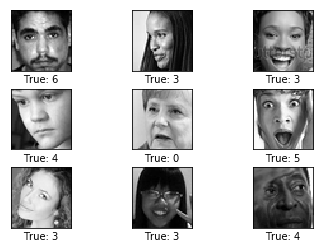

In [5]:
# Select random images from the train set
i = randint(0, len(imgs_train) - 9)

# Get the first images from the train-set.
images = imgs_train[i:i+9]

# Get the true classes for those images.
cls_true = labels_train_class[i:i+9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## Getting started in TensorFlow

### Placeholders
To input our images and labels, we need placeholders. `x` is our placeholder for the input images. `None` means we can have an arbitrary number of images and `img_size_flat` is the number of pixels for a single image.

In [6]:
# input images
x = tf.placeholder(tf.float32, [None, img_size_flat])
# one-hot encoded label for each image
y_true = tf.placeholder(tf.float32, [None, num_classes])
# one-dimensional vector with integer class
y_true_class = tf.placeholder(tf.int64, [None])

### Variables
The weights and biases to be optimized…

In [7]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))
biases = tf.Variable(tf.zeros([num_classes]))

### Linear Model
For the sake of simplicity, let's first define a fully connected linear model that does not use convolutions yet...

In [8]:
logits = tf.matmul(x, weights) + biases
# normalize the logits using the softmax function
y_pred = tf.nn.softmax(logits)
# convert one-hot encoded labels back to decimal
y_pred_class = tf.argmax(y_pred)

### Loss and Optimizer
Defining a loss function to be minimized. Cross entropy looks hard to grasp. The minimum of the loss function is found using gradient descent.

In [9]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_true)
loss = tf.reduce_mean(cross_entropy)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(loss)

# does the predicted class equal the true class?
correct_prediction = tf.equal(y_pred_class, y_true_class)
# reduce all the booleans to see the model accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Session and Initializing

In [10]:
session = tf.Session()
# initialize variables
session.run(tf.global_variables_initializer())

### Preparing to train

In [45]:
batch_size = 100

# one-hot encoding the datasets
labels_test = np.array(tf.one_hot(labels_test_class, num_classes).eval(session=session))
labels_train = np.array(tf.one_hot(labels_train_class, num_classes).eval(session=session))

# dict with the test-set data to be used as input to the graph
feed_dict_test = {x: imgs_test,
                  y_true: labels_test,
                  y_true_class: labels_test_class}

def print_accuracy():
    # Use TensorFlow to compute the accuracy.
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Print the accuracy.
    print("Accuracy on test-set: {0:.1%}".format(acc))
    

### Helper for optimizing-iterations
We need a couple of functions for getting a training batch of data and for making a single training iteration. 
For training, a random batch of 100 labeled images is taken from the dataset and is fed into the graph.

In [54]:
def next_batch(batch_size):
    # Generate start index
    i = randint(0, len(imgs_train) - batch_size)
    
    # Get the images and labels from the train set
    images = imgs_train[i:i+batch_size]
    labels = labels_train[i:i+batch_size]
    return images, labels

In [52]:
def optimize(num_iterations):
    accs = []
    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = next_batch(batch_size)
        
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        # Note that the placeholder for y_true_cls is not set
        # because it is not used during training.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)
        accs.append(session.run(accuracy, feed_dict=feed_dict_test))
    return accs

In [13]:
correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Accuracy without training

In [25]:
print_accuracy()

Accuracy on test-set: 13.0%


### Training the model
We are now training the model with 100 iterations using the simple linear model. To visualize the training proces, we are saving the accuracy after each training iteration and subsequently plotting the values.

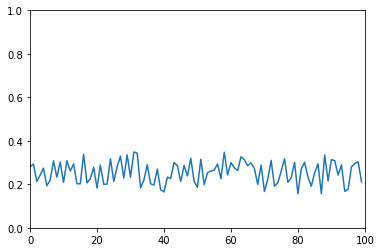

In [67]:
accuracys = optimize(num_iterations=100)
plt.plot(accuracys)
plt.axis([0, 100, 0, 1])
plt.show()

This looks pretty bad. The values are not converging at all. Looks like we need some convolutions!